## Example of feature selection and evaluating an ML model

In [ ]:
import pandas as pd
import os
import numpy as np
import pickle
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated", category=FutureWarning)

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_folder = os.path.join(parent_dir, 'data', 'processed')

train = pd.read_csv(os.path.join(data_folder, 'train_ptbxl_extracted_features.csv'))
test = pd.read_csv(os.path.join(data_folder, 'test_ptbxl_extracted_features.csv'))

train.drop(["Age", "Gender", "Patient_id", "Beat_P_idx", "Beat_Q_idx", "Beat_R_idx", "Beat_S_idx", "Beat_T_idx"], axis=1, inplace=True)
test.drop(["Age", "Gender", "Patient_id", "Beat_P_idx", "Beat_Q_idx", "Beat_R_idx", "Beat_S_idx", "Beat_T_idx"], axis=1, inplace=True)

In [3]:
train.head()

,RR_Prev,RR_Next,RR_Rate,PR_Int,PR_Seg,QRS,P_Wave,T_Wave,T_Left,QT,...,aVR_ST_std,aVL_ST_std,aVF_ST_std,V1_ST_std,V2_ST_std,V3_ST_std,V4_ST_std,V5_ST_std,V6_ST_std,Label
0,0.88,0.70,0.795455,0.13,0.06,0.07,0.07,0.03,0.02,0.16,...,0.021634,0.021556,0.014880,0.103124,0.137752,0.166207,0.151613,0.086737,0.053389,NORM
1,0.70,0.71,1.014286,0.01,0.05,0.18,0.06,0.05,0.03,0.29,...,0.027507,0.011024,0.027607,0.058074,0.067420,0.072164,0.084531,0.059523,0.051606,NORM
2,0.71,0.70,0.985915,0.12,0.07,0.10,0.05,0.05,0.03,0.29,...,0.041470,0.023491,0.023970,0.094179,0.070949,0.037184,0.062548,0.052488,0.049602,NORM
3,0.70,0.71,1.014286,0.14,0.10,0.12,0.04,0.03,0.01,0.21,...,0.029969,0.004940,0.026868,0.078919,0.059494,0.020795,0.033241,0.028266,0.035149,NORM
4,0.71,0.70,0.985915,0.10,0.05,0.11,0.05,0.04,0.02,0.31,...,0.048518,0.022195,0.032770,0.089511,0.070864,0.065697,0.082878,0.068134,0.062674,NORM


In [4]:
label_mapping = {label: i for i, label in enumerate(sorted(set(train["Label"])))}
label_mapping

{'MI': 0, 'NORM': 1}

In [5]:
ml_outcome_path = os.path.join(parent_dir, 'tests', 'ml_outcomes')

In [9]:
X_train = train.drop('Label', axis=1)
y_train = train['Label']

X_test = test.drop('Label', axis=1)
y_test = test['Label']

# Encode labels as integers starting from 0
label_mapping = {label: i for i, label in enumerate(sorted(set(y_train)))}
y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]

# Convert columns to pandas.Index with appropriate dtype to avoid the warning
X_train.columns = pd.Index(X_train.columns)
X_test.columns = pd.Index(X_test.columns)

# Feature selection using Recursive Feature Elimination (RFE)
xgb = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='error')
rfe = RFE(estimator=xgb, step=1, verbose=0)

# Fit RFE on the entire training data to get ranking
rfe.fit(X_train, y_train)

# Get the rankings of features and create a DataFrame
feature_ranks = pd.DataFrame({'Feature': X_train.columns, 'Rank': rfe.ranking_})

# Correctly select only rank 1 features
first_ranks = feature_ranks[feature_ranks['Rank'] == 1]['Feature'].values

# Use XGBoost to calculate the importance scores of rank 1 features
xgb = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='error')
xgb.fit(X_train[first_ranks], y_train)

# Get the feature importance scores from XGBoost
importance_scores = xgb.feature_importances_

# Sort the rank 1 features based on their importance scores
sorted_rank1_features = [feature for _, feature in sorted(zip(importance_scores, first_ranks), reverse=True)]

# Now 'sorted_rank1_features' contains the rank 1 features sorted in descending order of their importance.

# Evaluate model performance with different feature counts
num_features_to_evaluate = len(sorted_rank1_features)
results = []

for num_features in range(1, num_features_to_evaluate + 1):
    selected_features = sorted_rank1_features[:num_features]  # Select top 'num_features' features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    xgb.fit(X_train_selected, y_train)  # Train the model with selected features
    y_pred = xgb.predict(X_test_selected)  # Make predictions using the selected features

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((num_features, precision, recall, f1))

In [10]:
# Convert the 'results' list to a DataFrame
results_df = pd.DataFrame(results, columns=['Num Features', 'Precision', 'Recall', 'F1 Score'])
results_df.insert(loc=0, column="Feature Names", value = sorted_rank1_features)

os.makedirs(ml_outcome_path, exist_ok=True)
results_df.to_excel(f'{ml_outcome_path}/results_rfe_xgb.xlsx', index=False)

# Save necessary data for later use
plot_data = {
    'columns': X_train[first_ranks].columns,
    'importance_scores': importance_scores
}

# Serialize the plot data to a file using pickle
with open(f'{ml_outcome_path}/plot_data.pkl', 'wb') as f:
    pickle.dump(plot_data, f)

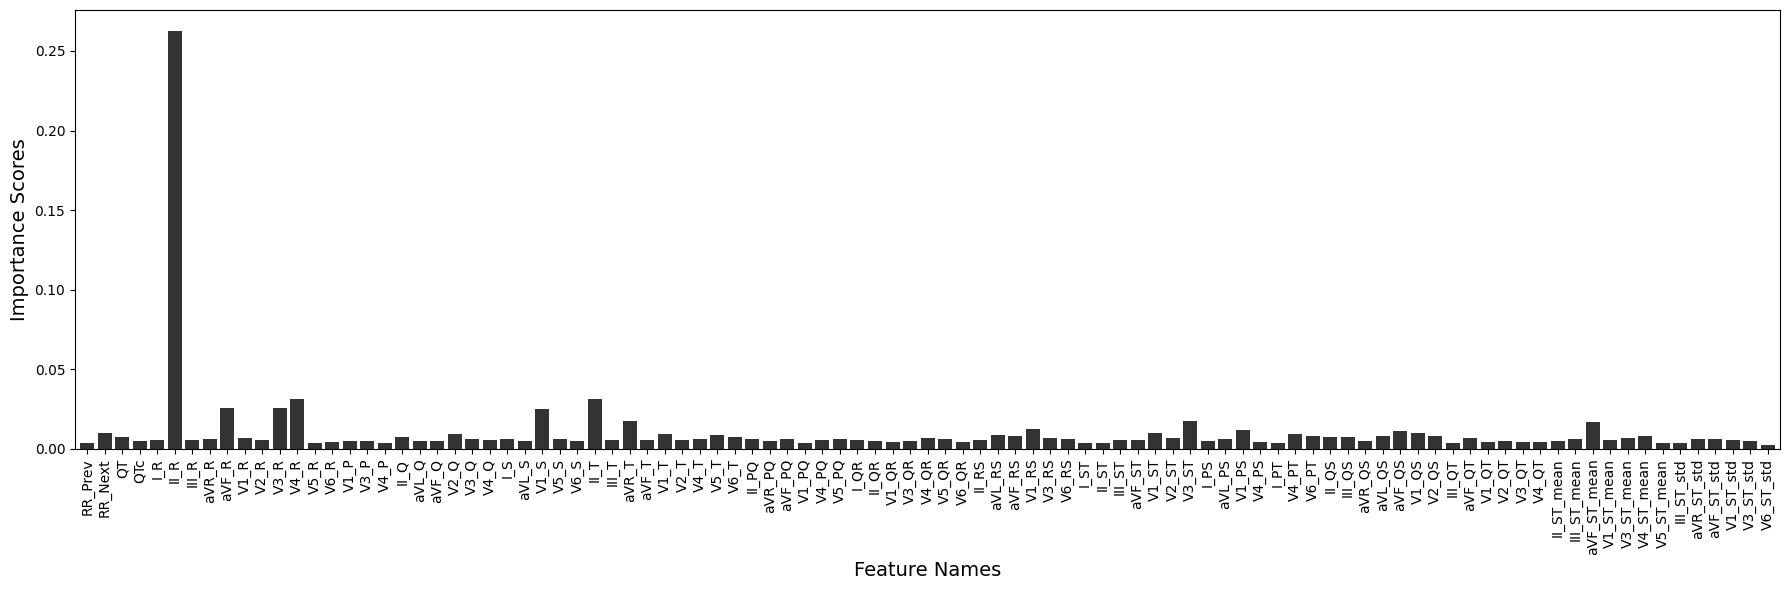

In [11]:
# Load the plot data from the pickle file
with open(f'{ml_outcome_path}/plot_data.pkl', 'rb') as f:
    loaded_plot_data = pickle.load(f)

# Create a bar plot using the loaded data
plt.figure(figsize=(18, 6))
plt.bar(loaded_plot_data['columns'], loaded_plot_data['importance_scores'], color='#333333')
plt.xticks(rotation=90)
plt.xlabel('Feature Names', fontsize=14)
plt.ylabel('Importance Scores', fontsize=14)
#plt.title('Feature Importance Scores')
plt.tight_layout()
plt.xlim(-0.7, len(loaded_plot_data['columns']) - 0.3)
plt.savefig(f'{ml_outcome_path}/feature_importance_bar_plot_dark.png', dpi = 300)  # Save the figure
plt.savefig(f'{ml_outcome_path}/feature_importance_bar_plot_dark.pdf')
plt.show()

---

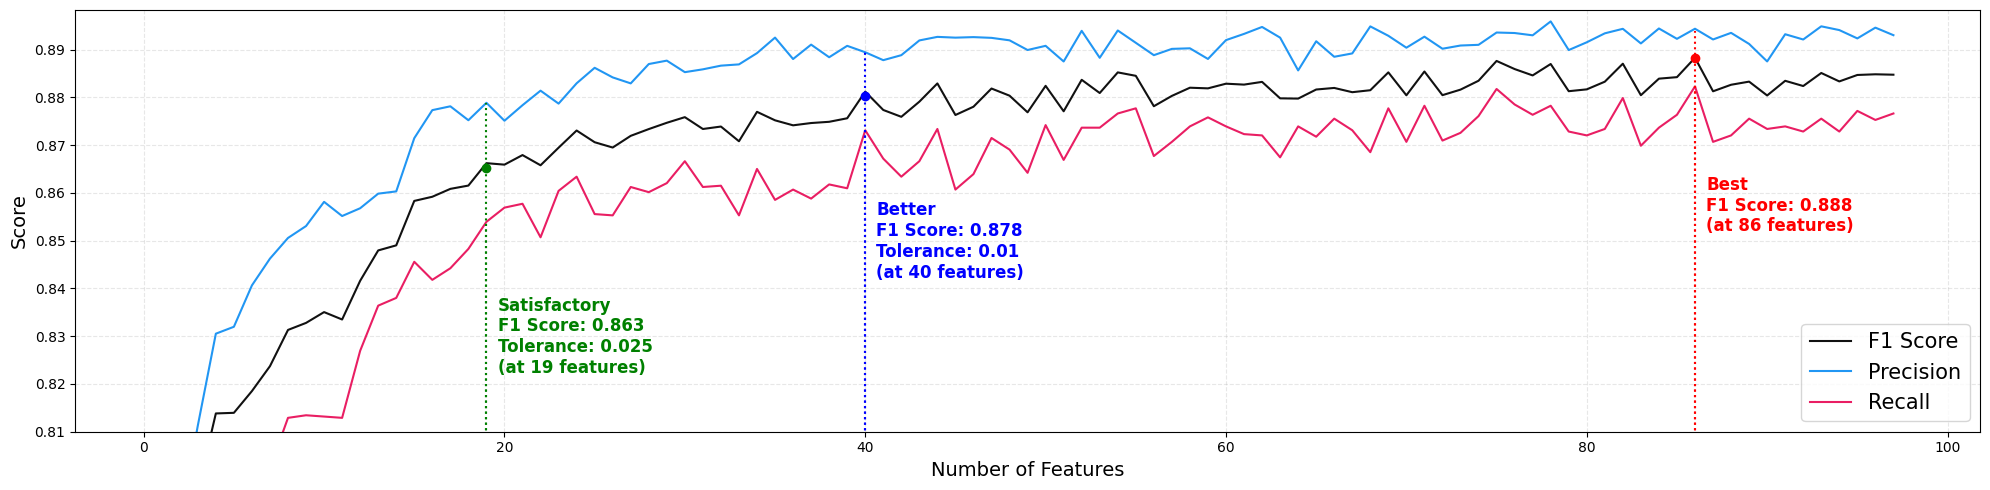

In [12]:
# Plot precision, recall, and F1 scores against number of features
num_features, precision, recall, f1_scores = zip(*results)

plt.figure(figsize=(20, 5))  # Set the figure size to be wider

# Plot scores
plt.plot(num_features, f1_scores, label='F1 Score', color='#111111')
plt.plot(num_features, precision, label='Precision', color='#2196F3')
plt.plot(num_features, recall, label='Recall', color='#E91E63')

# Find the F1-scores for the three chosen points
tolerance_1 = 0.01
tolerance_2 = 0.025

max_f1_score = max(f1_scores)
better_f1_score = max_f1_score - tolerance_1
even_better_f1_score = max_f1_score - tolerance_2

best_num_features = num_features[np.argmax(f1_scores)]
better_f1_num_features = None
even_better_f1_num_features = None

for num_feat, f1 in zip(num_features, f1_scores):
    if max_f1_score - f1 <= tolerance_1:
        better_f1_num_features = num_feat
        break

for num_feat, f1 in zip(num_features, f1_scores):
    if max_f1_score - f1 <= tolerance_2:
        even_better_f1_num_features = num_feat
        break

# Annotate the maximum F1 Score point with a red dot and text
plt.scatter([best_num_features], [max_f1_score], color='red', zorder=5)
plt.annotate(f'Best\nF1 Score: {max_f1_score:.3f}\n(at {best_num_features} features)',
             xy=(best_num_features, max_f1_score),
             xytext=(8, -125), textcoords='offset points', color='red', fontsize=12,  weight='bold')

# Annotate the better F1 Score point with a blue dot and text
plt.scatter([better_f1_num_features], [better_f1_score+0.002], color='blue', zorder=5)
plt.annotate(f'Better\nF1 Score: {better_f1_score:.3f}\nTolerance: 0.01\n(at {better_f1_num_features} features)',
             xy=(better_f1_num_features, better_f1_score),
             xytext=(8, -124), textcoords='offset points', color='blue', fontsize=12, weight='bold')

# Annotate the even better F1 Score point with a green dot and text
plt.scatter([even_better_f1_num_features], [even_better_f1_score+0.002], color='green', zorder=5)
plt.annotate(f'Satisfactory\nF1 Score: {even_better_f1_score:.3f}\nTolerance: 0.025\n(at {even_better_f1_num_features} features)',
             xy=(even_better_f1_num_features, even_better_f1_score),
             xytext=(8, -141), textcoords='offset points', color='green', fontsize=12, weight='bold')

plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Score', fontsize=14)
#plt.title('Performance vs. Feature Count', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0.81, max(f1_scores) + 0.01)  # Adjust the range to include the entire range of F1 scores

# Get the indices of better_f1_num_features and even_better_f1_num_features
if better_f1_num_features is not None:
    better_f1_index = num_features.index(better_f1_num_features)
else:
    better_f1_index = -1
    
if even_better_f1_num_features is not None:
    even_better_f1_index = num_features.index(even_better_f1_num_features)
else:
    even_better_f1_index = -1

# Draw dotted lines from scatter points to annotations for Precision
plt.plot([best_num_features, best_num_features], [0, max(precision)-0.002], color='red', linestyle='dotted')
if better_f1_index != -1:
    plt.plot([better_f1_num_features, better_f1_num_features], [0, precision[better_f1_index]], color='blue', linestyle='dotted')
if even_better_f1_index != -1:
    plt.plot([even_better_f1_num_features, even_better_f1_num_features], [0, precision[even_better_f1_index]], color='green', linestyle='dotted')

# Draw dotted lines from scatter points to annotations for Recall
plt.plot([best_num_features, best_num_features], [0, max(recall)], color='red', linestyle='dotted')
if better_f1_index != -1:
    plt.plot([better_f1_num_features, better_f1_num_features], [0, recall[better_f1_index]], color='blue', linestyle='dotted')
if even_better_f1_index != -1:
    plt.plot([even_better_f1_num_features, even_better_f1_num_features], [0, recall[even_better_f1_index]], color='green', linestyle='dotted')


plt.legend(loc='lower right', fontsize=15)
# Save the plot as an image file (e.g., PNG)
plt.tight_layout()
plt.savefig(f'{ml_outcome_path}/f1_score_plot_RFE_trim.png', dpi=300)
plt.savefig(f'{ml_outcome_path}/f1_score_plot_RFE_trim.pdf')

plt.show()  # Display the plot on the screen

In [13]:
# Save the relevant variables to a file using pickle
saved_data = {
    'num_features': num_features,
    'f1_scores': f1_scores,
    'precision_scores': precision,
    'recall_scores': recall,
    'max_f1_score': max_f1_score,
    'best_num_features': best_num_features,
    'better_f1_num_features': better_f1_num_features,
    'even_better_f1_num_features': even_better_f1_num_features,
    'better_f1_score': better_f1_score,
    'even_better_f1_score': even_better_f1_score
}

# Specify a file path to save the data
with open(f'{ml_outcome_path}/f1_score_plot_data.pkl', 'wb') as file:
    pickle.dump(saved_data, file)

In [14]:
# Load the saved data from the pickle file
pickle_filename = f'{ml_outcome_path}/f1_score_plot_data.pkl'
with open(pickle_filename, 'rb') as file:
    loaded_data = pickle.load(file)

# Retrieve the loaded data if needed for later use
num_features = loaded_data['num_features']
f1_scores = loaded_data['f1_scores']
precision = loaded_data['precision_scores']
recall = loaded_data['recall_scores']
max_f1_score = loaded_data['max_f1_score']
best_num_features = loaded_data['best_num_features']
better_f1_num_features = loaded_data['better_f1_num_features']
even_better_f1_num_features = loaded_data['even_better_f1_num_features']
better_f1_score = loaded_data['better_f1_score']
even_better_f1_score = loaded_data['even_better_f1_score']